<a href="https://colab.research.google.com/github/hhaller0826/ci2-fairness-ncm/blob/main/IntroFairnessNCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction/Explanation

Causal Inference [***TODO***: briefly explain the field of study & purpose of the notebook, especially as it relates to non-causal researchers]

---

### Table of Contents
**Section 1: Create a Causal Graph** 
This will walk you through creating a graph to represent relationships between the variables you plan to analyze. 

**Section 2: Train the Model**
This will walk you through creating a neural causal model, and training it to learn the relationships that are represented in your causal graph based on your data.

**Section 3: Extract Causal Insights from the Model**
This will provide instructions for extracting information about the causal relationships in your trained model. This may contain useful tools for your analysis, but does not contain any steps that are necessary for progressing to Section 4.

**Section 4: Project onto the Standard Fairness Model**
This will walk you through projecting your trained model onto a standard fairness model, which can then be used to perform fairness analysis. Note that the tools for extracting metrics described in Section 3 can also be applied to the resulting standard fairness model. 

**Section 5: Run Fairness Tasks** 
This will walk you through using your Standard Fairness Model projection to perform bias detection, fair prediction, and fair decision-making.

In [1]:
# Run this cell before you progress to ensure this notebook has access to the necessary code.
from src.graph.default_graphs import *
from src.graph.utils import *
from trashfiles.dummy_functions import *
from src.causalaibook.fusion import * 

# Create a Causal Graph

A causal graph (or "causal diagram") represents the relationships between the features in your data. Each node on the graph may represent one or more of these features. Please note that if a single node represents multiple features, we will not be able to distinguish between these features when doing causal analysis. 

If the values in one node may impact the values in another node, the graph will have a directed edge from the first node to the one that it affects. 

Sometimes there are confounders between two variables (lets call them A and B), meaning they are both directly impacted by the same third variable C. If C is one of the nodes on your graph, then there will be one directed edge from C to A, and another from C to B. If C is *not* one of the nodes on your graph, then we will create a bi-directed edge between A and B to signify that they are confounded. 

Examples of some graphs:

In [2]:
# TODO: add examples and plot them
# TODO: express how maybe X = ['race','age'] OR X1 = 'race' and X2 = 'age' 
# TODO: express how you don't need an arrow for indirect effects. Like if A-->B-->C we may not need an arrow A-->C.

# I am tryna give them the bare minimum of what they need to know to implement this. 

### Define your graph below.

You can use one of the pre-defined graphs, like so:
```
my_graph = get_predefined_graph(type='____')
```
Valid types include 'bow', 'backdoor', etc. ***TODO***


Alternatively, you create your own graph. Here is an example:
```
nodes = ['W', 'X', 'Y', 'Z']
edges = [('X', 'Y'),
        ('X', 'W'),
        ('Z', 'Y'),
        ('Z', 'W'),
        ('W', 'Y'),
        ('X', 'Z', 'bidirected'),
        ('Z', 'Y', 'bidirected')]

my_graph = CausalGraph(nodes=nodes, edges=edges)
```

*Remember*: when defining the directed, the arrow goes from the first node to the second one. So for example, ```edges = [('X', 'Y')]``` indicates one edge going from 'X' to 'Y'. When defining a bidirected edge, it does not matter which direction nodes are listed, but you must add the key term `'bidirected'` after listing the two nodes.

In [3]:
# using a pre-defined graph:
my_graph = parseGraph(get_predefined_graph('backdoor'))

# using a custom graph: 
nodes = ['A', 'B', 'C', 'D', 'E']
edges = [
    ('C', 'A', 'bidirected'),
    ('C', 'E'),
    ('C', 'D'),
    ('A', 'B'),
    ('A','E'),
    ('B','D'),
    ('B','E'),
    ('D','E')
]

my_graph = CausalGraph(nodes=nodes, edges=edges)

Double-check that this is the graph you want:

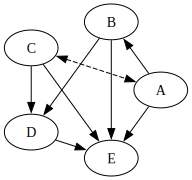

In [4]:
plot_causal_graph(my_graph)

# Train the Model
Explain NCM (model that learns the relationships between the variables in your graph based on your data).

### Complete the Structural Causal Model
Now that you have defined the graph we have the variables and dependencies, but we still need to define ___

In [5]:
data = process_data('path_to_data')

# This will define how we determine the probabilities for variables whose values 
# were not observed/recorded. 
distribution = 'probability distribution for exogenous variables'

# Now define which columns of your data correspond to each node in your graph:
assignments = {
    'A': ['race'],
    'B': ['skincolor'],
    'C': ['gender'],
    'D': ['job_title', 'degree', 'num_awards'],
    'E': ['salary']
}

my_model = Model(data=data, distribution=distribution, graph=CausalGraph(my_graph,assignments=assignments), assignments=assignments)
### NOTE for reviewers: if the assignment contains a feature which is not in the data
# or if there is a duplicate of the same feature, this will throw an error. 
# If there is a feature in the data that was not assigned to any variable it will output
# a warning but otherwise be fine


It is okay to exclude features from the model but they will not be used in the causal analysis.
Model assignments: {'A': ['race'], 'B': ['skincolor'], 'C': ['gender'], 'D': ['job_title', 'degree', 'num_awards'], 'E': ['salary']}



/Users/Hanita/causal/ci2-fairness-ncm/trashfiles/dummy_functions.py:68: UserWarning: The following features were not assigned to any variable: {'age'}
  warnings.warn('The following features were not assigned to any variable: {}'.format(unassigned_features), UserWarning)


When training the network, you are able to manually adjust various settings called "hyperparameters". These include the following:
* `pipeline_choice`: this specifies the type of neural network that will be ran. The options are as follows,
    * `'mle'`: Maximum Likelihood Estimator
    * `'gan'`: Generative Adversarial Network
    * `'ffn'`: Feed Forward Network
    The default is 'mle'. 
* `n-epochs`: the number of epochs, or passes through the dataset to complete during the training phase, to run. Default: 1000. 
* `batch-size`: number of training examples to use in each training epoch. 
* `gpu`: the GPU to use, if you have one. Default: none

You may set some, none, or all of these values manually. Valid definitions include:
```
hyperparameters = {
    'pipeline_choice': 'gan',
    'n-epochs': 500
}
```
```
hyperparameters = {}
```
```
hyperparameters = {
    'pipeline_choice': 'ffn',
    'n-epochs': 4600,
    'batch-size': 4,
    'gpu': gpu
}
```

In [6]:
# Set your parameters here:
hyperparameters = {
    'pipeline_choice': 'gan'
}

# And train the model:
run_training(my_graph, my_model, hyperparameters)

training ran with: 
 Graph: <trashfiles.dummy_functions.CausalGraph object at 0x119379790> 
 Model: <trashfiles.dummy_functions.Model object at 0x11a9c3770> 
 Params: {'pipeline_choice': 'gan'}


# Extract Causal Insights from the Model
Now that you have a trained model, you can use it to evaluate cause-effect relationships in your data. The metrics that you can evaluate are split into three categories: (1) values that can be computed directly from the data, (2) values that would occur if you force a variable to take on a certain value, and (3) questions about would have occurred if things had been different (I need to reword that so bad).

### Observational Understanding
Observational metrics can be calculated directly from the data. These include calculating standard probabilities and conditional probabilities (ex.: $P(Y=1)$ or $P(Y=1|X=0)$), as well as something called the "total variation".

*Total Variation (TV)*: a measure of how much the distribution of some variable *Y* is impacted by the value of a given attribute X.
$$TV_{x_0,x_1}(Y) = P(Y|X=x_1)-P(Y|X=x_0)$$

The available observational measures are defined as follows:
* `probability(variable, value, evidence)`: This will calculate the probability that a variable equals a certain value given the dictionary of evidence. The dictionary of conditional evidence is optional.
    * `probability('Y',1)` will return $P(Y=1)$
    * `probability('Y',1,{'X':0,'Z':2})` will return $P(Y=1|X=0,Z=2)$
* `total_variation(variable, value, attr, aval0, aval1)` will return the total variation of the given variable relative to the given attribute. $TV_{aval0,aval1}(variable=value)$. `avail1` is an optional value, and will default to "not avail0" if left blank. 
    * `total_variation('Y',1,'X',x0,x1)` will return $TV_{x_0,x_1}(Y=1) = P(Y=1|X=x_1)-P(Y=1|X=x_0)$

In [7]:
total_variation('Y', 1, 'X', 0, 1)

'P(Y=1 | X=1) - P(Y=1 | X=0)'

### Interventional Metrics
Interventional metrics arise when you actively say "what if we force this variable to take on a certain value?"
The difference between a conditional probability ($P(Y|X=x)$) and an interventional one ($P(Y|do(X=x))$) is that when you force an event to happen, you emancipate it from all other influences. [kinda stole this wording from the book of why but not exactly...]

*For example*: say that patients who go to the doctor for a certain illness all recieve advice and prescription medication, and this allows them to heal within a week. Say that those who have not recieved the advice nor the medication don't heal so quickly.

If we are trying to evaluate the likelihood that someone has healed, and we note that they have recieved the advice, we can assume from our data that they went to the doctor and recieved medication too. 

Essentially, $P(\text{healed} | \text{advice})=P(\text{healed} | \text{advice},\text{medication})$.

But what if a patient hears the doctor's advice from a friend? In this case, even though the patient has heard the advice, they may not have seen the doctor, and they may not have access to the medication. This is an example of an intervention. Although we can usually assume that someone who has heard the advice has seen a doctor, the friend intervened and gave the patient advice, so even though we know the patient has heard the advice, we don't have any knowledge of whether or not they went to a doctor and recieved medication. Here, $P(\text{healed} | \text{advice})\neq P(\text{healed} | do(\text{advice}))$.

*Total Effect (TE)*:

*z-Total Effect (z-TE)*:

The available interventional measures are defined as follows:
* `probability(variable, value, evidence, intervention)`: This will calculate the probability that a variable equals a certain value given the dictionary of evidence, and the dictionary of interventions. Both dictionaries are optional.
    * `probability('Y',1,{'X':0},{'Z':1})` will return $P(Y=1 | X=0, do(Z=1))$
    * `probability('Y',1,intervention={'Z':1})` will return $P(Y=1 | do(Z=1))$
* TE
* z-TE

In [17]:
evid = [
    ('A', 1),
    ('B', 2)
]
cond = [
    ('C', 3)
]
total_effect('Y', e=evid, c=cond)

'P(Y_{C=3} | A_{C=3}=1, B_{C=3}=2)'

### What-ifs [rename]
Some kinda explanation.

Options:
* ETT
* PN/PS
* PNS
* DE
* IE

In [9]:
ev = [
    ('A', 1),
]
cond = [
    ('A', 0)
]
ett('Y', e=ev, c=cond)

'P(Y_{A=0} | A=1)'

# Project onto the Standard Fairness Model

The standard fairness model (SFM) is a model whose graph has four nodes:
* *X*: The protected attribute. This ***fill in explanation***
* *Z*: The counfounding variables. This ***fill in explanation***
* *W*: The mediator variables. This ***fill in explanation***
* *Y*: The outcome variable. This ***fill in explanation***

When projecting onto the SFM, you should select one of your model's variables to be *X* and one to be *Y*, but you may assign multiple variables as confounders or mediators. Counfounders may have any relationship to the other confounders, and mediators may have any relationship with the other mediators, however there is a specific structure that must exist between *X*, *Z*, *W*, and *Y*:
* *Y* must be a variable that has 0 arrows pointing toward *X*, *Z*, or *W*.
* *W* must contain variables that have 0 arrows pointing toward *X* or *Z*.
* *X* and *Z* cannot have arrows pointing towards each other, but they may have a bidirected arrow between them. 

**Here is an example**:
Given the following graph. 

![example1graph.png](img/example1graph.png)

Based on this graph, you could do either of the following projections:
```
projection1 = {
    'X': 'e',
    'Z': ['a', 'b'],
    'W': ['c', 'd'],
    'Y': 'f'
}
```

or 
```
projection2 = {
    'X': 'a',
    'Z': ['e'],
    'W': ['b', 'c', 'd'],
    'Y': 'f'
}
```

![](img/ex1projection1.png) ![](img/ex1projection2.png)

The following would **not** be a valid projection: 
```
bad_projection = {
    'X': 'a',
    'Z': ['b', 'e'],
    'W': ['c', 'd'],
    'Y': 'f'
}
```
because there is an arrow from the `X` variable (containing `'a'`) to the `Z` variable (containing `'b'`). This indicates that `X` may actually cause `Z`, rather than just being confounded with `Z`. 

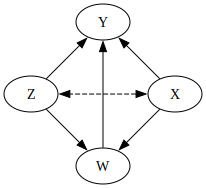

In [10]:
# Specify your projection here:
projection = {
    'X': 'C',
    'Z': ['A', 'B'],
    'W': ['D'],
    'Y': 'E'
}
sfm = project_to_sfm(my_model.cg, projection) # TODO: validity check, should clock if the relationships arent valid.

# Confirm that this is the projection you intended:
sfm.plot()

# Run Fairness Tasks

(This will have a lot of the same tasks & suggestions as Drago's git thinggy https://dplecko.github.io/CFA/)

Most fairness analysis can be split into three general tasks: (1) bias detection and quantification, (2) fair prediction, and (3) fair decision-making. (***TODO***: elaborate)

### Task 1: Bias Detection & Quantification
Here we will evaluate "fairness measures" which can determine whether discrimination is present within a dataset, and indicate how strong that discrimination is.

1. *Direct Effect (DE)* indicates whether your protected attribute *X* is directly impacting your outcome variable *Y*. 

2. *Indirect Effect (IE)* indicates whether your outcome variable is being indirectly impacted by your protected attribute. 

For example, if *X* denotes race and *Y* denotes salary, "direct effect" would indicate whether two identical candidates of different races would be given the same salary, whereas "indirect effect" would indicate that a candidate's race impacts some other attribute which in turn impacts salary. For example, if race causes educational discrimination, and salary is impacted by a candidate's degree level, then race would indirectly impact salary. 

3. *Spurious Effect (SE)* indicates whether there are variables that causally affect both your outcome variable and protected attribute, causing them to be correlated. 

For example, race causally affects an individual's hair color (if they are not of European descent, then there is an incredibly high likelihood that they will have black hair). If race also affects salary (directly or indirectly), then there will be a spurious effect of hair color on salary, even though hair color itself does not directly or indirectly impact a candidate's salary. 

The *Total Variation (TV)*, a measure of how much the distribution of *Y* is impacted by the value of a given attribute, can be calculated from the direct, indirect, and spurious effects. 

The `fairness_cookbook` below will calculate and store bias detection information. Once it is defined, you can use it to print and plot bias detection data. 

In [11]:
# create your cookbook
fcb = fairness_cookbook(data, sfm.X, sfm.W, sfm.Z, sfm.Y, x0=0, x1=1)

# Get your data:
autoplot(fcb, decompose='xspec', dataset=data)

pretend this is a graph
x-SPECIFIC
	ETT_[x0=0,x1=1](y|x) = value
	Ctf-SE_[x0=0,x1=1](y) = value
	Ctf-DE_[x0=0,x1=1](y|x) = value
	Ctf-IE_[x0=0,x1=1](y|x) = value


### Task 2: Fair Prediction 
More detailed explanation of this task with examples. 

In [12]:
fair_pred = fair_predictions(data, sfm, x0=0, x1=1, bn='ie')

# You can now obtain predictions on new data
preds = predict(fair_pred, data)
data['fair_predictions'] = preds

# And decompose the predictions on the evaluation set
faircause_decomposition = fairness_cookbook(data, sfm.X, sfm.W, sfm.Z, 'fair_predictions', x0=0, x1=1)
# You can now run the same quantification that you did with the cookbook under task 1

### Task 3: Fair Decision-Making
More detailed explanation of this task with examples. 

In [13]:
resp_oc = fair_decisions(data, sfm, x0=0, x1=1, po_transform='', po_diff_sign=1)

Now analyze important aspects of decision-making. Options for 'type' include:
* "decision": decomposition of D
* "delta": decomposition of Delta
* "benefit_fairness": inspect benefit fairness

In [14]:
# analyze important aspects of decision-making
autoplot(resp_oc, type = "decision")

pretend this is a graph
x-SPECIFIC
	ETT_[x0=0,x1=1](y|x) = value
	Ctf-SE_[x0=0,x1=1](y) = value
	Ctf-DE_[x0=0,x1=1](y|x) = value
	Ctf-IE_[x0=0,x1=1](y|x) = value
